In [81]:
import os
import torch
import pandas as pd
import PIL.Image
from loguru import logger
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [82]:
metadata = pd.read_csv('metadata.csv')
metadata.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [83]:
len_fake , len_real = len(metadata[metadata['label'] == "FAKE"]),len(metadata[metadata['label'] == "REAL"])
logger.info(f"FAKE为{len_fake} --- REAL为{len_real}")

2025-04-13 16:16:44.911 | INFO     | __main__:<module>:2 - FAKE为79341 --- REAL为16293


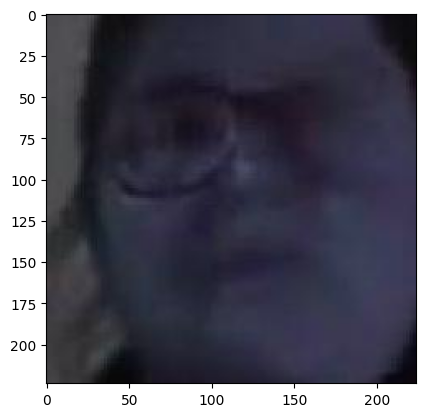

In [96]:
image_path = 'faces_224'
img_path = os.path.join(image_path,np.random.choice(list(os.listdir(image_path))))
plt.imshow(cv2.imread(img_path))

In [105]:
import os
import torch
import pandas as pd
from torch.utils.data import Dataset, random_split,DataLoader
from torchvision import transforms
from PIL import Image

metadata = pd.read_csv('modified_file.csv')

class ImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, split='train', split_ratio=0.8, random_seed=42):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        
        # 验证必要列是否存在
        assert 'videoname' in self.df.columns, "CSV需要包含videoname列"
        assert 'label' in self.df.columns, "CSV需要包含label列"
        
        # 划分训练/测试集
        self._split_data(split, split_ratio, random_seed)
        
    def _split_data(self, split, split_ratio, random_seed):
        """根据split参数划分数据集"""
        from sklearn.model_selection import train_test_split
        
        # 确保可重复性
        torch.manual_seed(random_seed)
        
        # 划分训练测试集
        train_idx, test_idx = train_test_split(
            range(len(self.df)),
            train_size=split_ratio,
            stratify=self.df['label'],  # 分层抽样保持类别比例
            random_state=random_seed
        )
        
        if split == 'train':
            self.df = self.df.iloc[train_idx].reset_index(drop=True)
        else:
            self.df = self.df.iloc[test_idx].reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['videoname'])
        
        # 加载图片
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            img = Image.new('RGB', (224, 224), color='black')  # 创建黑色占位图
        
        # 转换标签（支持字符串和数值标签）
        label = row['label']
        if isinstance(label, str):
            label = 1 if label.lower() in ['fake', '1', 'true'] else 0
        
        # 应用变换
        if self.transform:
            img = self.transform(img)
            
        return img, torch.tensor(label, dtype=torch.long)

# 数据增强配置
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 使用示例
if __name__ == "__main__":
    # 创建数据集
    train_dataset = ImageDataset(
        df = metadata,
        img_dir='faces_224',
        transform=train_transform,
        split='train'
    )
    
    test_dataset = ImageDataset(
        df = metadata,
        img_dir='faces_224',
        transform=test_transform,
        split='test'
    )
    
    # 创建DataLoader
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=32,
        shuffle=False,
    )
    
    # 验证
    print(f"训练集样本数: {len(train_dataset)}")
    print(f"测试集样本数: {len(test_dataset)}")
    sample_img, sample_label = next(iter(train_loader))
    print(f"批量图片形状: {sample_img.shape}")  # 应为 torch.Size([32, 3, 224, 224])
    print(f"批量标签形状: {sample_label.shape}")  # 应为 torch.Size([32])

训练集样本数: 76507
测试集样本数: 19127
批量图片形状: torch.Size([32, 3, 224, 224])
批量标签形状: torch.Size([32])


In [108]:

import torch.nn as nn
from torchvision.models import resnext50_32x4d

def build_resnext50(num_classes=2, pretrained=True):
    """修复后的模型构建函数"""
    try:
        if pretrained:
            # 方法2：使用明确指定的权重
            model = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1)
        else:
            model = resnext50_32x4d(weights=None)
            
        # 修改最后一层
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        
        return model
        
    except Exception as e:
        print(f"加载失败: {e}")
        # 方法3：降级方案
        print("正在尝试不使用预训练权重...")
        model = resnext50_32x4d(pretrained=False)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        return model

model = build_resnext50(num_classes=2, pretrained=True)
model

加载失败: name 'ResNeXt50_32X4D_Weights' is not defined
正在尝试不使用预训练权重...


/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

KeyboardInterrupt: 

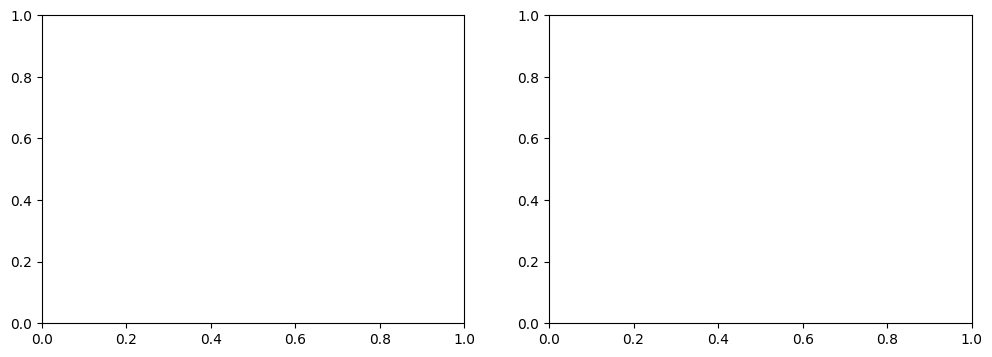

In [111]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import models

# 1. 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnext50_32x4d(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 二分类
model = model.to(device)

# 2. 训练配置
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

def train(model, train_loader, val_loader=None, epochs=10):
    history = {'train_loss': [], 'val_acc': []}
    
    plt.ion()  # 开启交互模式
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    for epoch in range(epochs):
        # 训练阶段
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
        
        # 记录训练损失
        epoch_loss = running_loss / len(train_loader)
        history['train_loss'].append(epoch_loss)
        
        # 验证阶段
        if val_loader:
            val_acc = evaluate(model, val_loader)
            history['val_acc'].append(val_acc)
            print(f'Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.2f}%')
        else:
            print(f'Epoch {epoch+1} - Loss: {epoch_loss:.4f}')
        
        # 更新学习率
        scheduler.step()
        
        # 实时可视化
        update_plots(ax1, ax2, history, epoch+1)
    
    plt.ioff()
    plt.show()
    return history

def evaluate(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100 * correct / total

def update_plots(ax1, ax2, history, epoch):
    ax1.clear()
    ax2.clear()
    
    # 损失曲线
    ax1.plot(history['train_loss'], 'b-', label='Train Loss')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # 准确率曲线
    if history['val_acc']:
        ax2.plot(history['val_acc'], 'r-', label='Val Accuracy')
        ax2.set_title('Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
    
    plt.tight_layout()
    plt.draw()
    plt.pause(0.1)

# 示例用法
if __name__ == "__main__":

    
    # 开始训练
    history = train(model, train_loader, test_loader, epochs=5)
    
    # 保存模型
    torch.save(model.state_dict(), 'resnext50_trained.pth')